# Проект
### Обзор функций, которые используются в проекте

In [3]:
import cv2
import numpy as np
import imutils
import random
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans

На первом этапе проводится предварительная обработка изображений, которая включает в себя удаление шума, повышение резкости изображений. С помощью этой обработки выделяются характерные детали, подавляется шум, повышается быстродействие, уменьшается объем информации

In [19]:
image = cv2.imread('img/lis.jpg')

In [20]:
# Преобразование изображения в оттенки серого
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [21]:
# Удаление шума с помощью фильтра Гаусса
denoised = cv2.GaussianBlur(gray, (5, 5), 0)

# Повышение резкости с помощью фильтра увеличения резкости
sharpness = cv2.filter2D(denoised, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))

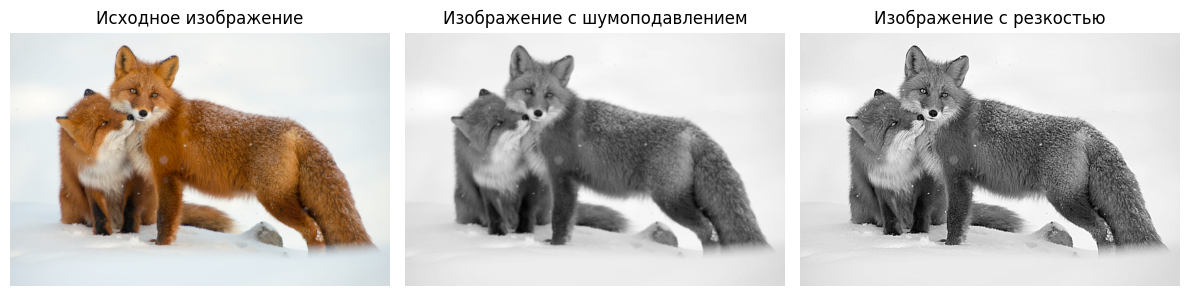

In [22]:
# Вывод результатов
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(132)
plt.imshow(denoised, cmap='gray')
plt.title('Изображение с шумоподавлением')
plt.axis('off')

plt.subplot(133)
plt.imshow(sharpness, cmap='gray')
plt.title('Изображение с резкостью')
plt.axis('off')

plt.tight_layout()
plt.show();

Следующий шаг – удалении фона на изображении, для этого 
сканируется все пространство изображения и отсканированные пиксели с одинаковой интенсивностью обнуляются. В результате интересующие нас объекты будут более четко выделены на черном фоне.

Функция def shelf () предназначена для удаления фона. В процессе работы этой программы сканируется все строки, начиная с 
верхней. Если при сканировании интенсивности пикселей не меняются, то они обнуляются. В результате на изображении фон становится 
темным

In [25]:
def shelf(image_path):
    image = cv2.imread(image_path)
    
    # Конвертация изображения в оттенки серого
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Бинаризация изображения
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    # Поиск контуров объекта
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Создание маски для удаления фона
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    
    # Применение маски на изображение
    result = cv2.bitwise_and(image, image, mask=mask)
    
    # Отображение изображений до и после удаления фона
    plt.figure(figsize=(12, 4))
    plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Исходное изображение'), plt.axis('off')
    plt.subplot(122), plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB)), plt.title('Изображение без фона'), plt.axis('off')
    plt.show();

In [26]:
image_path = 'img/lis.jpg'

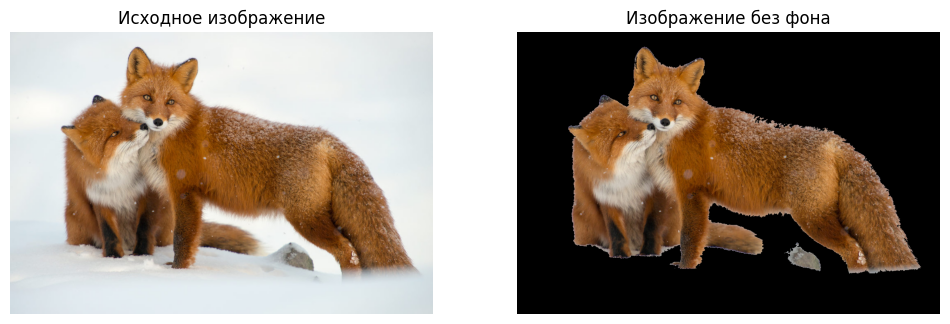

In [27]:
shelf(image_path)

Для выделения объектов используется операция сегментации 
изображения методом водораздела, с последующей маркировкой результата сегментации. Функция segment() предназначена 
для разбиения всего поля изображения на сегменты.

In [28]:
def segment(img):
    # Конвертация в оттенки серого
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Применение порогового преобразования для получения черно-белого изображения
    im_bw = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)[1]
    plt.imshow(im_bw, cmap='gray'), plt.axis('off'), plt.title('Пороговое преобразование'), plt.show()
    
    # Применение морфологической операции открытия для удаления шума
    kernel = np.ones((4, 3), np.uint8)
    opening = cv2.morphologyEx(im_bw, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Дилатация для получения заднего плана
    sure_bg = cv2.dilate(opening, kernel, iterations=1)
    
    # Применение преобразования расстояния для получения переднего плана
    dist_transform = cv2.distanceTransform(sure_bg, cv2.DIST_L2, 3)
    ret, sure_fg = cv2.threshold(dist_transform, 0.01 * dist_transform.max(), 255, cv2.THRESH_BINARY)
    sure_fg = np.uint8(sure_fg)
    
    # Применение алгоритма Canny для обнаружения границ
    unknown = cv2.Canny(sure_bg, 700, 100, apertureSize=3)
    plt.imshow(unknown, cmap='gray'), plt.title('Canny преобразование'), plt.axis('off'), plt.show()
    
    # Соединение компонентов связности
    ret, mark = cv2.connectedComponents(sure_fg)
    mark = mark + 1
    mark[unknown]
    
    # Применение операции водораздела
    markers = cv2.watershed(img, mark)
    
    # Пометка областей, которые не удалось сегментировать
    img[markers == -1] = [255, 0, 0]
    
    return img

In [32]:
imgor = cv2.imread('img/mag2.jpg')

In [38]:
# Изменение размера изображения
img = cv2.resize(imgor, (800, 800))

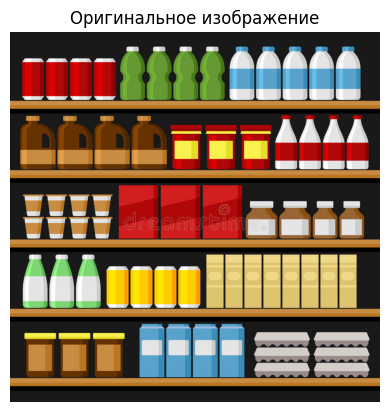

In [39]:
plt.imshow(cv2.cvtColor(imgor, cv2.COLOR_BGR2RGB))
plt.title('Оригинальное изображение')
plt.axis('off')
plt.show();

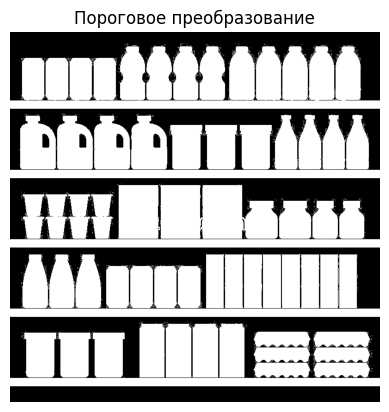

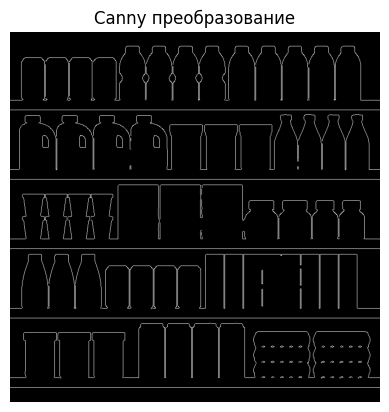

In [40]:
# Вызов функции для сегментации изображения
marker = segment(img)

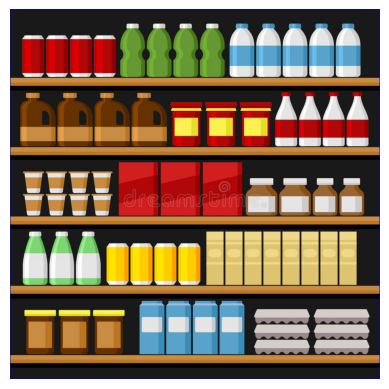

In [41]:
# Вывод результата сегментации
plt.imshow(cv2.cvtColor(marker, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show();

С помощью операции распознавания объекта по шаблону каждый объект охватывается прямоугольной рамкой.
Распознавание объекта по шаблону. Метод заключается в поиске 
объекта на большом изображении, который соответствует выбранному шаблону.

In [51]:
def match_template(image_path, template_path):
    image = cv2.imread(image_path)
    template = cv2.imread(template_path)
    
    # Преобразование изображения и шаблона в оттенки серого
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    
    # Применение функции сопоставления шаблона
    result = cv2.matchTemplate(gray_image, gray_template, cv2.TM_CCOEFF_NORMED)
    
    # Установка порога для определения соответствия
    threshold = 0.8
    loc = np.where(result >= threshold)
    
    # Рисование прямоугольных рамок вокруг найденных соответствий
    for pt in zip(*loc[::-1]):
        cv2.rectangle(image, pt, (pt[0] + template.shape[1], pt[1] + template.shape[0]), (0, 255, 0), 2)
    
    # Отображение результатов
    plt.figure(figsize=(12, 4))
    
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
    plt.title('Шаблон')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))   
    plt.title('Распознавание объекта по шаблону')
    plt.axis('off')
    plt.show();

In [52]:
image_path = 'img/mag2.jpg'
template_path = 'img/pic2.jpg'

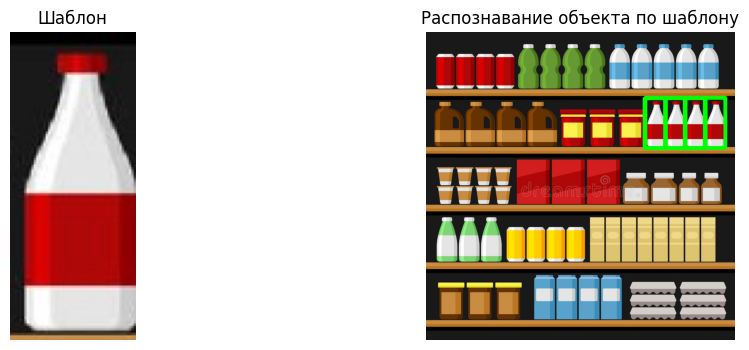

In [53]:
match_template(image_path, template_path)

### Создание таблицы признаков

На основе массива точек изображения и массива координат контура вычисляются все признаки объекта

In [65]:
img = cv2.imread('img/mag2.jpg', 0)

In [66]:
# Применение адаптивной бинаризации для получения бинарного изображения
th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

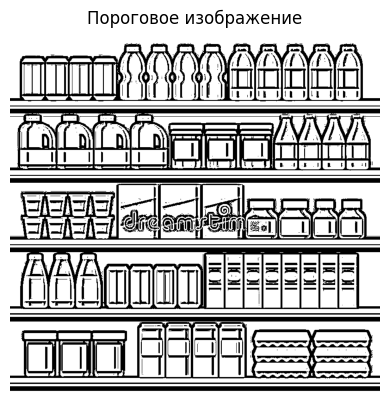

In [67]:
# Отображение бинарного изображения
plt.imshow(th, cmap='gray')
plt.title('Пороговое изображение')
plt.axis('off')
plt.show()

In [68]:
# Нахождение контуров на бинарном изображении
contours, hierarchy = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnt = contours[0]

# Вычисление параметров контура
area = cv2.contourArea(cnt)
perimeter = cv2.arcLength(cnt, True)
hull = cv2.convexHull(cnt)

# Ограничивающий прямоугольник контура
x, y, w, h = cv2.boundingRect(cnt)

# Рисование ограничивающего прямоугольника на изображении
image_with_rectangle = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

In [69]:
print("Координата x:", x)
print("Координата y:", y)
print("Ширина прямоугольника:", w)
print("Высота прямоугольника:", h)

Координата x: 0
Координата y: 776
Ширина прямоугольника: 800
Высота прямоугольника: 24


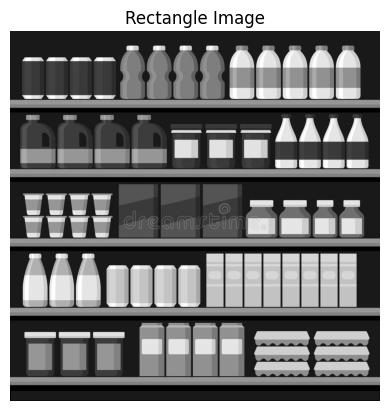

In [70]:
imag = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
plt.imshow(imag, cmap='gray')
plt.title('Rectangle Image')
plt.axis('off')
plt.show();

In [71]:
# Вычисление дополнительных параметров контура
epsilon = 0.1 * cv2.arcLength(cnt, True)
aspect_ratio = float(w) / h
rect_area = w * h
extent = float(area) / rect_area
hull_area = cv2.contourArea(hull)
equi_diameter = np.sqrt(4 * area / np.pi)

In [74]:
# Создание маски для контура
mask = np.zeros(img.shape, np.uint8)
cv2.drawContours(mask, [cnt], 0, 255, -1);

In [75]:
# Вычисление моментов контура
M = cv2.moments(cnt)

pixelpoints = np.transpose(np.nonzero(mask))
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(img, mask=mask)

In [76]:
# Нахождение самых левой, правой, верхней и нижней точки контура
leftmost = tuple(cnt[cnt[:, :, 0].argmin()][0])
rightmost = tuple(cnt[cnt[:, :, 0].argmax()][0])
topmost = tuple(cnt[cnt[:, :, 1].argmin()][0])
bottommost = tuple(cnt[cnt[:, :, 1].argmax()][0])

In [77]:
# Выво значений параметров
print("Площадь:", area)
print("Периметр:", perimeter)
print("Ширина, Высота:", w, h)
print("Соотношение сторон:", aspect_ratio)
print("Отношение площади к ограничивающему прямоугольнику:", extent)
print("Площадь выпуклой оболочки:", hull_area)
print("Эквивалентный диаметр:", equi_diameter)
print("Моменты:", M)
print("Самая левая точка:", leftmost)
print("Самая правая точка:", rightmost)
print("Самая верхняя точка:", topmost)
print("Самая нижняя точка:", bottommost)

Площадь: 18377.0
Периметр: 1644.0
Ширина, Высота: 800 24
Соотношение сторон: 33.333333333333336
Отношение площади к ограничивающему прямоугольнику: 0.9571354166666667
Площадь выпуклой оболочки: 18377.0
Эквивалентный диаметр: 152.96510423491395
Моменты: {'m00': 18377.0, 'm10': 7341611.5, 'm01': 14471887.5, 'm20': 3910631725.6666665, 'm11': 5781519056.25, 'm02': 11397421525.666666, 'm30': 2343446061605.75, 'm21': 3079622483962.5, 'm12': 4553269899503.833, 'm03': 8976745389543.75, 'mu20': 977657931.4166665, 'mu11': 0.0, 'mu02': 810119.4166660309, 'mu30': 0.0, 'mu21': 0.0001220703125, 'mu12': -7.152557373046875e-05, 'mu03': 0.001953125, 'nu20': 2.894927536231884, 'nu11': 0.0, 'nu02': 0.002398831873172919, 'nu30': 0.0, 'nu21': 2.66638905546754e-15, 'nu12': -1.5623373371880116e-15, 'nu03': 4.266222488748064e-14}
Самая левая точка: (0, 776)
Самая правая точка: (799, 799)
Самая верхняя точка: (0, 776)
Самая нижняя точка: (0, 799)


### Распознавание объектов с помощью нейронной сети

Алгоритм распознавания объектов.
1. По вычисленным признакам всех объектов проводится обучение нейросети, т. е. для каждого объекта по его признакам определяется значение на выходе нейросети и заносится в последнюю 
строку таблицы. Таким образом каждому объекту сопоставляется 
маркер.
2. Сравнение данных из базы признаков с признаками неизвестного объекта позволяет распознать этот объект и определить его маркер.

In [78]:
s = [1249.0, 577.0, 180.5, 7795.5, 163.0, 111.0, 909.5, 29.5]
p = [157.55, 141.34, 90.476, 1262.1, 61.799, 78.064, 175.47, 48.730]
w = [31, 51, 7, 66, 15, 5, 24, 5]
h = [54, 26, 41, 158, 22, 37, 70, 22]
kw = [0.574, 1.9615, 0.1707, 0.4177, 0.6818, 0.1351, 0.3429, 0.2272]
ks = [0.7461, 0.4351, 0.6289, 0.7475, 0.4939, 0.6, 0.5414, 0.2682]
d = [39.878, 27.105, 15.160, 99.627, 14.406, 11.888, 34.029, 6.1287]
m0 = [1249.0, 577.0, 180.5, 7795.5, 163.0, 111.0, 909.5, 29.5]
m1 = [15994, 18479, 3319.8, 255475, 790.83, 174.5, 8059.0, 40.833]
m2 = [27883, 4990.2, 1440.7, 616222, 1220.3, 2033.3, 21165, 160.5]
m3 = [307788, 175877, 180.5, 19613900, 4657.8, 3300.2, 153434, 152.375]
weights = [0.3, 0.5, 0.1, 0.2, 1, 1, 1, 1, 1, 1, 1]

In [79]:
def sum(a, b):
    assert(len(a) == len(b))
    output = 0
    for i in range(len(a)):
        output += (a[i] * b[i])
    return output

In [80]:
def art_neuron(input, weights):
    pred = sum(input, weights)
    return pred

In [81]:
in0 = [s[0], p[0], w[0], h[0], kw[0], ks[0], d[0], m0[0], m1[0], m2[0], m3[0]]
in1 = [s[1], p[1], w[1], h[1], kw[1], ks[1], d[1], m0[1], m1[1], m2[1], m3[1]]
in2 = [s[2], p[2], w[2], h[2], kw[2], ks[2], d[2], m0[2], m1[2], m2[2], m3[2]]
in3 = [s[3], p[3], w[3], h[3], kw[3], ks[3], d[3], m0[3], m1[3], m2[3], m3[3]]
in4 = [s[4], p[4], w[4], h[4], kw[4], ks[4], d[4], m0[4], m1[4], m2[4], m3[4]]
in5 = [s[5], p[5], w[5], h[5], kw[5], ks[5], d[5], m0[5], m1[5], m2[5], m3[5]]

In [82]:
print("Входные данные 0:", in0)
print("Входные данные 5:", in5)

Входные данные 0: [1249.0, 157.55, 31, 54, 0.574, 0.7461, 39.878, 1249.0, 15994, 27883, 307788]
Входные данные 5: [111.0, 78.064, 5, 37, 0.1351, 0.6, 11.888, 111.0, 174.5, 2033.3, 3300.2]


In [83]:
pred0 = art_neuron(in0, weights)
pred1 = art_neuron(in1, weights)
pred2 = art_neuron(in2, weights)
pred3 = art_neuron(in3, weights)
pred4 = art_neuron(in4, weights)
pred5 = art_neuron(in5, weights)

In [84]:
print("Результат предсказания 0:", pred0)
print("Результат предсказания 1:", pred1)
print("Результат предсказания 2:", pred2)
print("Результат предсказания 3:", pred3)
print("Результат предсказания 4:", pred4)
print("Результат предсказания 5:", pred5)

Результат предсказания 0: 353422.5731
Результат предсказания 1: 200206.7716
Результат предсказания 2: 5245.747600000001
Результат предсказания 3: 20496501.1922
Результат предсказания 4: 6933.2112
Результат предсказания 5: 5711.8551
